In [50]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

from mpmath import mp
mp.dps = 1000

In [51]:
from Calculation.StationaryState import StationaryState   
        
st_state = StationaryState()

In [53]:
H1k1_hyst = 7.5e3
H1k2_hyst = 6.5e3
H2k_hyst = 12.5e3

thickness = 12e-7
Ms_hyst = 620.

Ku_1ord, Ku_2ord, J_hyst = Hk2KuJ(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, thickness)

#setting up film parameters
film_inst_single = LayeredFilm.from_file('default_single')
film_inst_double = LayeredFilm.from_file('default_double')

film_inst_single.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=True)
film_inst_double.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=False)


#print("single layered")
#film_inst_single.print()
#print("double layered")
#film_inst_double.print()

In [54]:
H = symbols("H", real=True, positive=True)
Htet, Hphi = symbols("theta_H phi_H", real=True)
Ms = symbols("Ms", real=True, positive=True)
Mtet = symbols("theta_M1 theta_M2", real=True)
Mphi = symbols("phi_M1 phi_M2", real=True)
A, Ku2, gamma, alpha = symbols("A K_u2 gamma alpha", real=True, positive=True)
J = symbols("J", real=True)
Hk1, Hk2, H2k = symbols("H_k1 H_k2 H2_k", real=True, positive=True)
t = symbols("t", real=True, positive=True)

In [55]:
Ev1 = -Ms * H * (sym.sin(Htet) * sym.sin(Mtet[0]) * sym.cos(Hphi - Mphi[0]) +
                 sym.cos(Htet) * sym.cos(Mtet[0])) + \
      A * (sym.sin(Mtet[0]) ** 2) + \
      Ku2 * (sym.sin(Mtet[0]) ** 4)

Ev2 = -Ms * H * (sym.sin(Htet) * sym.sin(Mtet[1]) * sym.cos(Hphi - Mphi[1]) +
                 sym.cos(Htet) * sym.cos(Mtet[1])) + \
      A * (sym.sin(Mtet[1]) ** 2) + \
      Ku2 * (sym.sin(Mtet[1]) ** 4)

Es = t * Ev1 + t * Ev2 + \
     J * (sym.sin(Mtet[0]) * sym.sin(Mtet[1]) * sym.cos(Mphi[1] - Mphi[0]) +
          sym.cos(Mtet[0]) * sym.cos(Mtet[1]))

In [56]:
sys_mat = np.zeros((4,4), dtype=sym.Add)

sys_vars = [Mtet[0], Mphi[0], Mtet[1], Mphi[1]]
diff_vars = [Mphi[0], Mtet[0], Mphi[1], Mtet[1]]
for i in range(4):
    for j in range(4):
        sys_mat[i][j] = (gamma / Ms) * (1 / t) * Es.diff(diff_vars[i], sys_vars[j])
        if i%2==1:
            sys_mat[i][j] = -sys_mat[i][j]

lamb = symbols("lambda", complex=True)

for i in range(2):
    sys_mat[i][i] += lamb*sym.sin(Mtet[0])
    
for i in range(2, 4):
    sys_mat[i][i] += lamb*sym.sin(Mtet[1])

sys_mat[0][1] += alpha*lamb*sym.sin(Mtet[0])**2
sys_mat[2][3] += alpha*lamb*sym.sin(Mtet[1])**2

sys_mat[1][0] += -alpha*lamb
sys_mat[3][2] += -alpha*lamb
    
sys_mat = sym.Matrix(sys_mat)

# subs for PMA
sys_mat = sys_mat.subs({
    Hphi: 0, Mphi[0]: 0, Mphi[1]: 0
})
sys_mat = sys_mat.subs({
    Ku2: Ms * Hk2 / 4,
    A: Ms * (Hk1 - Hk2) / 2,
    J: (t / 2) * Ms * (H2k - Hk1)
})
sys_mat.simplify()

In [57]:
#sys_mat

In [58]:
sys_det = sys_mat.det(method='berkowitz')
sys_det_collected = sym.collect(sym.expand(sys_det), lamb)
sys_pow_coefs = []
for i in range(5):
    sys_pow_coefs.append(sys_det_collected.coeff(lamb, i))

In [59]:
p4 = sym.factor(sys_pow_coefs[4]).subs({alpha**2: 0})

In [60]:
#p4

In [61]:
p3 = sym.collect(sym.expand(sys_pow_coefs[3]), gamma)
p3 = sym.factor(sym.collect(p3, alpha)).subs({1+alpha**2: 1})
p3 = sym.expand(sym.expand_trig(p3))
p3 = sym.simplify(sym.factor(p3))

In [62]:
#p3

In [63]:
p2 = sym.collect(sym.expand(sys_pow_coefs[2]), gamma)
p2 = sym.collect(p2, alpha).subs({alpha**2: 0})
p2 = sym.expand(sym.expand_trig(p2))
p2 = sym.simplify(sym.factor(p2))

In [64]:
#p2

In [65]:
p1 = sym.collect(sym.expand(sys_pow_coefs[1]), gamma)
p1 = sym.collect(p1, alpha)
p1 = sym.expand(sym.expand_trig(p1))
p1 = sym.factor(p1)

In [66]:
#p1

In [67]:
p0 = sym.collect(sym.expand(sys_pow_coefs[0]), gamma)
p0 = simplify(sym.factor(sym.expand_trig(p0)))

In [68]:
#p0

In [139]:
p0_sym, p1_sym, p2_sym, p3_sym, p4_sym = symbols("p_0 p_1 p_2 p_3 p_4", real=True)
p_syms = [p0_sym, p1_sym, p2_sym, p3_sym, p4_sym]
w_sym = symbols("w", real=True)

w_sol = sym.solve(p4_sym*(w_sym**4) - p2_sym*(w_sym**2) + p0_sym, w_sym)

w_sol_subs = w_sol.copy()
for i in range(4):
    w_sol_subs[i] = w_sol_subs[i].subs({
        p4_sym: p4,
        p2_sym: p2,
        p0_sym: p0
    })

In [197]:
varset = (
    H, Htet,
    Ms, Mtet[0], Mtet[1],
    Hk1, Hk2, H2k,
    t,
    gamma
)

f_sol_lamb = []
for eq in w_sol_subs:
    f_sol_lamb.append(sym.lambdify(varset, eq/(2*sym.pi), 'numpy'))

f_sol_lamb = np.array(f_sol_lamb)

In [198]:
beta_sym = symbols('beta', real=True)

In [199]:
lamb_im = []
lamb_im.append(0)

for i in range(1, 5):
    tmp = sym.expand((sym.I*w_sym-beta_sym)**i)
    lamb_im.append(sym.cancel(sym.im(tmp)/w_sym))

for im in lamb_im:
    display(im)

0

1

-2*beta

3*beta**2 - w**2

-4*beta**3 + 4*beta*w**2

In [200]:
eq = sym.Rational(0, 1)
for i in range(5):
    eq+=lamb_im[i]*p_syms[i]

eq = sym.collect(sym.expand(eq), beta_sym)
eq

-4*beta**3*p_4 + 3*beta**2*p_3 + beta*(-2*p_2 + 4*p_4*w**2) + p_1 - p_3*w**2

In [201]:
b_sol = sym.solve(eq, beta_sym)

In [202]:
#sym.simplify(b_sol[0].subs({w_sym: w_sol[1]}))
#b_sol[0]

In [203]:
#b_sol[1]

In [204]:
#b_sol[2]

In [205]:
b_sqrt3 = b_sol[0].args[0].args[1].args[0]
#b_sqrt3

In [206]:
b_sqrt2 = b_sqrt3.args[0].args[1].args[0]
#b_sqrt2

In [207]:
#b_sol.append(b_sqrt3)
#b_sol.append(b_sqrt2)

In [208]:
for i in range(len(b_sol)):
    b_sol[i] = b_sol[i].subs({
        p4_sym: p4,
        p3_sym: p3,
        p2_sym: p2,
        p1_sym: p1,
        p0_sym: p0
    })

In [209]:
varset = (
    H, Htet,
    Ms, Mtet[0], Mtet[1],
    Hk1, Hk2, H2k,
    t,
    gamma, alpha, w_sym
)

b_sol_lamb = []
for eq in b_sol:
    b_sol_lamb.append(sym.lambdify(varset, eq, 'numpy'))

In [210]:
class ExpConfig:
    def __init__(self, film_inst, Habses, Htet):
        self.film_inst = film_inst
        self.H = np.array(Habses)
        self.Htet = Htet
        
        self.max_ang = []
        self.min_ang = []
        
        for H_cur in self.H:
            Hvec = pol2cart(H_cur, self.Htet, 0.)
            
            angles = st_state.get_angles_optimize_static(
                self.film_inst,
                Hvec,
                tol=1e-8
            )
            self.max_ang.append(max( angles[0]%(2*np.pi) ,  angles[2]%(2*np.pi) ))
            self.min_ang.append(min( angles[0]%(2*np.pi) ,  angles[2]%(2*np.pi) ))
                
            
class FreqResults:
    def __init__(self, config, index = np.arange(4)):
        self.config = config
        self.H = self.config.H
        
        self.freq = []
        
        for f_lamb in f_sol_lamb[index]:
            freq_tmp = []
            
            for i in range(len(self.H)):
                H_cur = self.H[i]
                film_inst_l1 = self.config.film_inst.l1.st
                freq_tmp.append(
                    f_lamb(
                        H_cur, self.config.Htet,
                        film_inst_l1.Ms, self.config.min_ang[i], self.config.max_ang[i],
                        H1k1_hyst, H1k2_hyst, H2k_hyst, #-!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                        film_inst_l1.t,
                        film_inst_l1.gamma
                    )
                )
                
            self.freq.append(np.array(freq_tmp))
            

exp_config = ExpConfig(film_inst_double, np.linspace(1e3, 6e3, 100), np.deg2rad(63.))
results_double = FreqResults(exp_config)

In [211]:
class BetaResults:
    def __init__(self, freq_results):
        self.freq_results = freq_results
        self.config = freq_results.config
        self.H = self.config.H
        
        self.beta = [] #freq, beta
        for freq_arr in self.freq_results.freq:
            beta_f_tmp = []
            
            for b_lamb in (b_sol_lamb):
                beta_fb_tmp = []
                
                for i in range(len(self.H)):
                    H_cur = self.H[i]
                    
                    film_inst_l1 = self.config.film_inst.l1.st
                    beta_fb_tmp.append(
                        b_lamb(
                            H_cur + 0.j, self.config.Htet,
                            film_inst_l1.Ms, self.config.min_ang[i], self.config.max_ang[i],
                            H1k1_hyst, H1k2_hyst, H2k_hyst,
                            film_inst_l1.t,
                            film_inst_l1.gamma,
                            film_inst_l1.alpha,
                            2*np.pi*freq_arr[i]
                        )
                    )
                beta_f_tmp.append(np.array(beta_fb_tmp))
            self.beta.append(beta_f_tmp)
            

results_beta = BetaResults(results_double)

In [212]:
tau_exp_d = np.array([
    100,
    100,
    91,
    60,
    63
])

tau_num_s = np.array([
    109.8,
    84.0,
    76.6,
    71.2,
    64.9
])

tau_num_d = np.array([
    110.2,
    89.7,
    85.5,
    87.1,
    92.2
])

dr_exp = pd.read_csv('data/moke/double_results_experimental.txt', sep='\t')
dr_exp

,H,A1,f,df,tau_f,d_tau_f,A2,tau2,A3,tau3
0,1530,2.4,8.7,0.3,113.7,20.5,3.7,226.8,693,3044395
1,2295,4.3,9.8,0.2,115.0,16.0,5.0,202.0,3800,2947127
2,3060,5.5,11.0,0.2,114.0,16.0,8.7,349.0,-,-
3,3825,7.6,12.2,0.2,63.7,5.0,15.0,237.0,-,-
4,4590,11.0,12.9,0.1,73.6,4.0,19.8,217.0,-,-


Text(0.5, 0, 'H Oe')

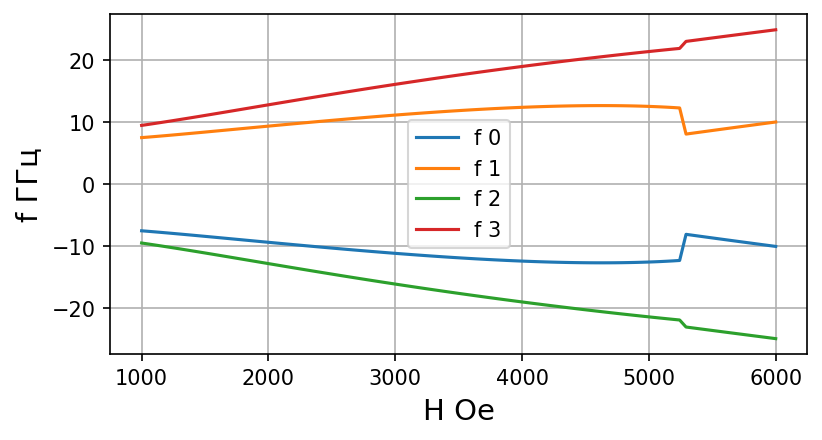

In [213]:
%matplotlib inline
plt.figure(figsize=(6, 3), dpi=150)

for i in [0, 1, 2, 3]:
    plt.plot(results_beta.H, results_beta.freq_results.freq[i]*1e-9, label="f {}".format(i))

plt.grid(True)
plt.legend()
plt.ylabel("f ГГц", fontsize=14)
plt.xlabel("H Oe", fontsize=14)

In [216]:
#%matplotlib notebook
#plt.figure(figsize=(6, 4), dpi=150)
#
#tmp_freq_ind = 3
#
#for beta_ind in range(3,4):
#    beta_plot = results_beta.beta[tmp_freq_ind][beta_ind]
#    plt.plot(results_beta.H, np.real(beta_plot), label="f{}:b{} - real".format(tmp_freq_ind, beta_ind))
#    plt.plot(results_beta.H, np.imag(beta_plot), label="f{}:b{} - imag".format(tmp_freq_ind, beta_ind))
#    
#
#plt.grid(True)
#plt.legend()

c:\users\sasha\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


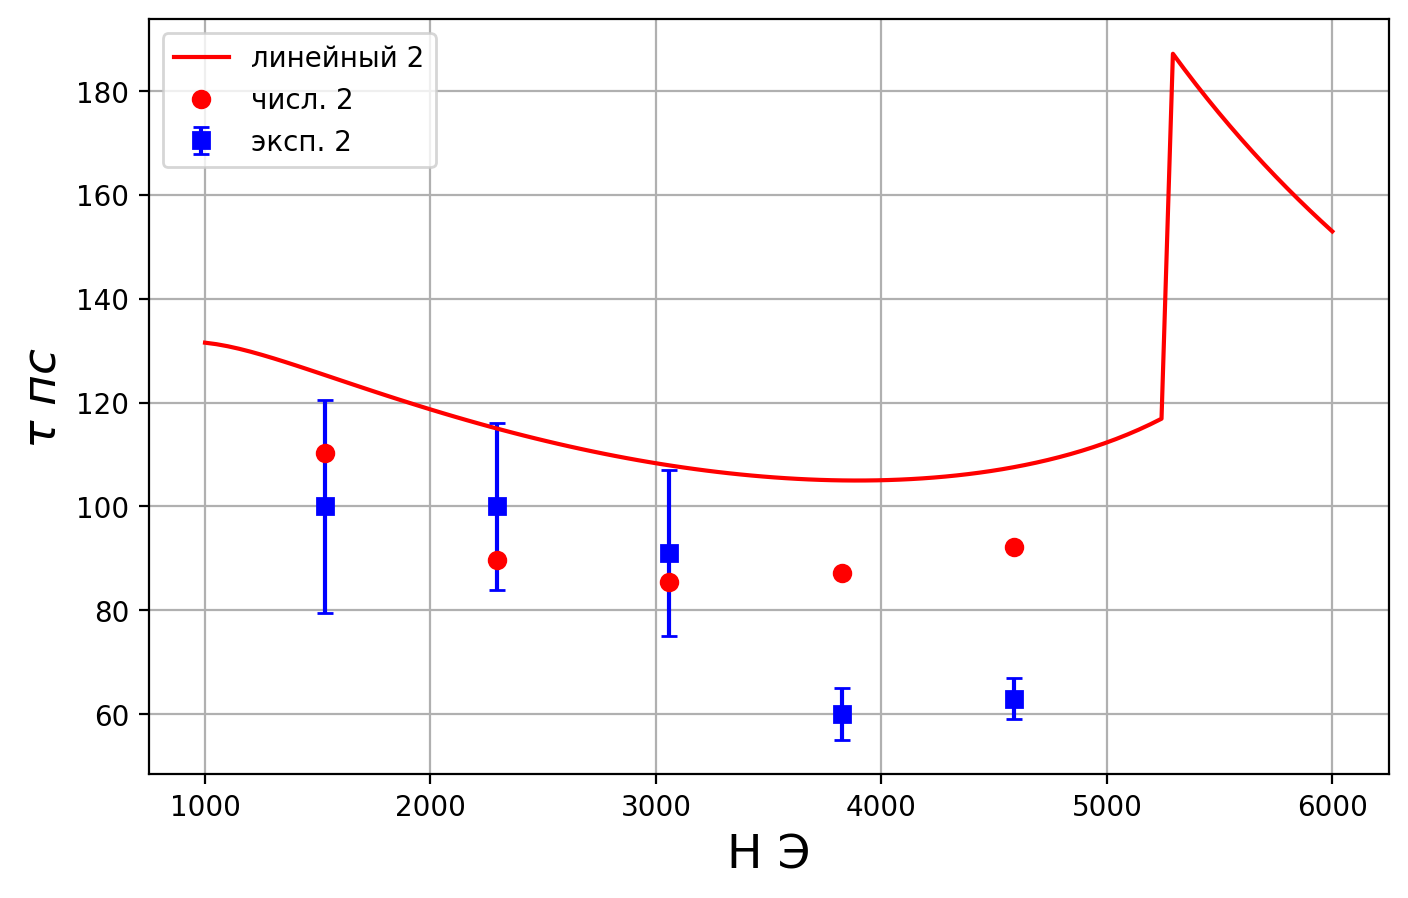

In [217]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)

plt.plot(results_beta.H, 1e12/np.array(results_beta.beta[1][0]), label='линейный 2', color='r')
#plt.plot(results_beta.Hax, 1e12/np.array(results_beta.res_beta[1]), label='линейный 2')# getting complex values
#plt.plot(results_beta.Hax, 1e12/np.array(results_beta.res_beta[2]), label='линейный 2')# getting complex values
plt.plot(dr_exp.H, tau_num_d, 'ro', label='числ. 2')
#plt.errorbar(dr_exp.H, dr_exp.tau_f, yerr=2*dr_exp.d_tau_f,fmt='bs', label='эксп. 2')
plt.errorbar(dr_exp.H, tau_exp_d, yerr=dr_exp.d_tau_f, fmt='bs', label='эксп. 2',elinewidth=1.5, capsize=3)
plt.xlabel('H Э',fontsize=17)
plt.ylabel(r"$\tau\ пс$",fontsize=17)
plt.grid(True)
plt.legend()

In [218]:
sym.im(sys_mat)

Matrix([
[sin(theta_M1)*im(lambda), alpha*sin(theta_M1)**2*im(lambda),                        0,                                 0],
[       -alpha*im(lambda),          sin(theta_M1)*im(lambda),                        0,                                 0],
[                       0,                                 0, sin(theta_M2)*im(lambda), alpha*sin(theta_M2)**2*im(lambda)],
[                       0,                                 0,        -alpha*im(lambda),          sin(theta_M2)*im(lambda)]])

In [219]:
a_coefs_re = np.zeros((4,4), dtype=sym.Add)
a_coefs_im = np.zeros((4,4), dtype=sym.Add)
a_coefs_re_subs = np.zeros((4,4), dtype=sym.Add)
a_coefs_im_subs = np.zeros((4,4), dtype=sym.Add)

for i in range(4):
    for j in range(4):
        a_coefs_re[i][j] = symbols("a{}{}_r".format(i, j), real=True)
        a_coefs_im[i][j] = symbols("a{}{}_i".format(i, j), real=True)
        
        a_coefs_re_subs[i][j] = sym.re(sys_mat[i,j])
        a_coefs_im_subs[i][j] = sym.im(sys_mat[i,j])
        
        

In [220]:
Amat = np.zeros((4,4), dtype=sym.Add)
for i in range(4):
    for j in range(4):
        if sym.re(sys_mat[i, j]) != 0:
            Amat[i][j] += a_coefs_re[i][j]
            
        if sym.im(sys_mat[i, j]) != 0:
            Amat[i][j] += sym.I*a_coefs_im[i][j]

Amat = sym.Matrix(Amat)

In [221]:
Amat

Matrix([
[I*a00_i + a00_r, I*a01_i + a01_r,               0,           a03_r],
[I*a10_i + a10_r, I*a11_i + a11_r,           a12_r,               0],
[              0,           a21_r, I*a22_i + a22_r, I*a23_i + a23_r],
[          a30_r,               0, I*a32_i + a32_r, I*a33_i + a33_r]])

In [222]:
vars_sol = symbols("v0 v1 v2 v3", complex=True) #sys_vars = [Mtet[0], Mphi[0], Mtet[1], Mphi[1]]
v_eqs = [0, 0, 0]
for i in range(3):
    for j in range(4):
        v_eqs[i] += (vars_sol[j])*Amat[i + 1, j]

v_sol = sym.solve(v_eqs, [vars_sol[1], vars_sol[2], vars_sol[3], vars_sol[0]])

In [223]:
vars_sol

(v0, v1, v2, v3)

In [224]:
v_mult = []
for i in range(1, 4):
    v_mult.append(sym.simplify( v_sol[vars_sol[i]]/vars_sol[0] ))

In [225]:
for i in range(4):
    for j in range(4):
        for k in range(len(v_mult)):
            v_mult[k] = v_mult[k].subs({
                a_coefs_re[i][j]: a_coefs_re_subs[i][j],
                a_coefs_im[i][j]: a_coefs_im_subs[i][j]
          })

for i in range(len(v_mult)):
    v_mult[i] = v_mult[i].subs({lamb: sym.I*w_sym-beta_sym})

In [226]:
tmp_varset = (
    H, Htet,
    Ms, Mtet[0], Mtet[1],
    Hk1, Hk2, H2k,
    t,
    gamma, alpha, 
    w_sym, beta_sym
)

v_mult_lamb = []
for i in range(len(v_mult)):
    v_mult_lamb.append(sym.lambdify(tmp_varset, v_mult[i], 'numpy'))
    
v_mult_lamb = np.array(v_mult_lamb)

In [227]:
exp_config_for_phase = ExpConfig(film_inst_double, np.linspace(100, 5e3, 1000), np.deg2rad(63.))
freq_results_for_phase = FreqResults(exp_config_for_phase)
beta_results_for_phase = BetaResults(freq_results_for_phase)

In [228]:
class PhaseResults:
    def __init__(self, beta_results):
        self.beta_results = beta_results
        self.freq_results = beta_results.freq_results
        self.config = beta_results.config
        self.H = self.config.H
        
        self.mult = []# freq, beta, v_mult_lamb
        
        for freq_ind in range(len(self.freq_results.freq)):
            freq_arr = self.freq_results.freq[freq_ind]
            mult_f_tmp = []
            
            for beta_ind in range(len(self.beta_results.beta[freq_ind])):
                beta_arr = self.beta_results.beta[freq_ind][beta_ind]
                mult_fb_tmp = []
                
                for mult_lamb in v_mult_lamb:
                    mult_fbm_tmp = []
                    
                    for i in range(len(self.H)):
                        H_cur = self.H[i]
                        
                        film_inst_l1 = self.config.film_inst.l1.st
                        mult_fbm_tmp.append(
                            mult_lamb(
                                H_cur, self.config.Htet,
                                film_inst_l1.Ms, self.config.min_ang[i], self.config.max_ang[i],
                                H1k1_hyst, H1k2_hyst, H2k_hyst,
                                film_inst_l1.t,
                                film_inst_l1.gamma,
                                film_inst_l1.alpha,
                                2*np.pi*freq_arr[i],
                                #1./(90e-12),
                                beta_arr[i]
                            )
                        )
                        
                    mult_fb_tmp.append(np.array(mult_fbm_tmp))
                mult_f_tmp.append(mult_fb_tmp)
            self.mult.append(mult_f_tmp)
        
        
        #self.mult_phase
        #
        #for freq_ind in range(len(self.freq_results.freq)):
        #    for beta_ind in range(len(self.beta_results.beta[freq_ind])):
        #        for mult_ind in range(len(self.mult[freq_ind][beta_ind])):
                    


phase_results = PhaseResults(beta_results_for_phase)

<IPython.core.display.Javascript object>


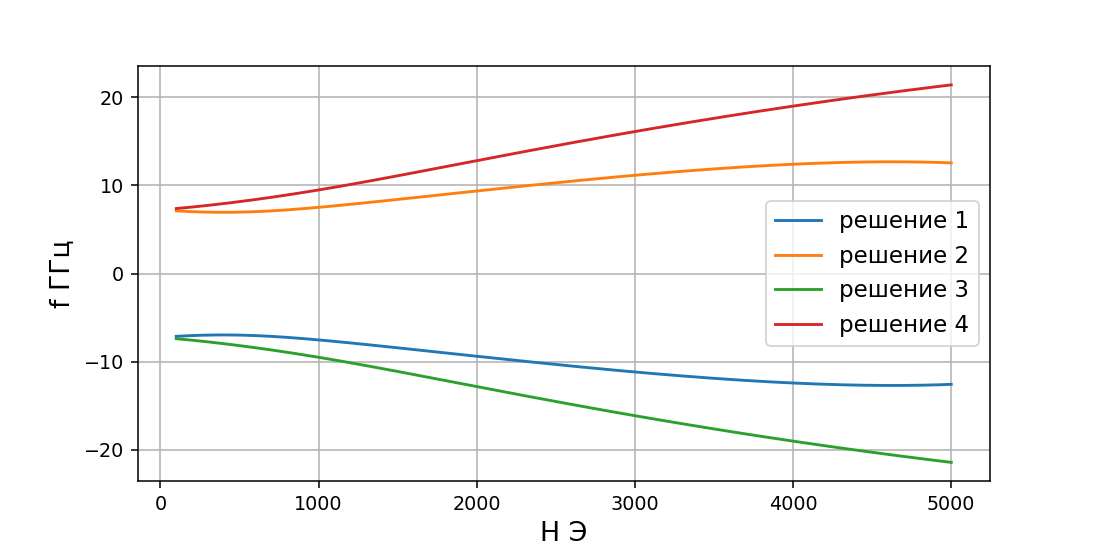

Text(0.5, 0, 'H Э')

In [230]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for freq_ind in range(len(phase_results.freq_results.freq)):
    plt.plot(phase_results.H, phase_results.freq_results.freq[freq_ind]*1e-9, label="решение {}".format(freq_ind+1))

plt.grid(True)
plt.legend(fontsize=12)
plt.ylabel("f ГГц", fontsize=14)
plt.xlabel("H Э", fontsize=14)

<IPython.core.display.Javascript object>


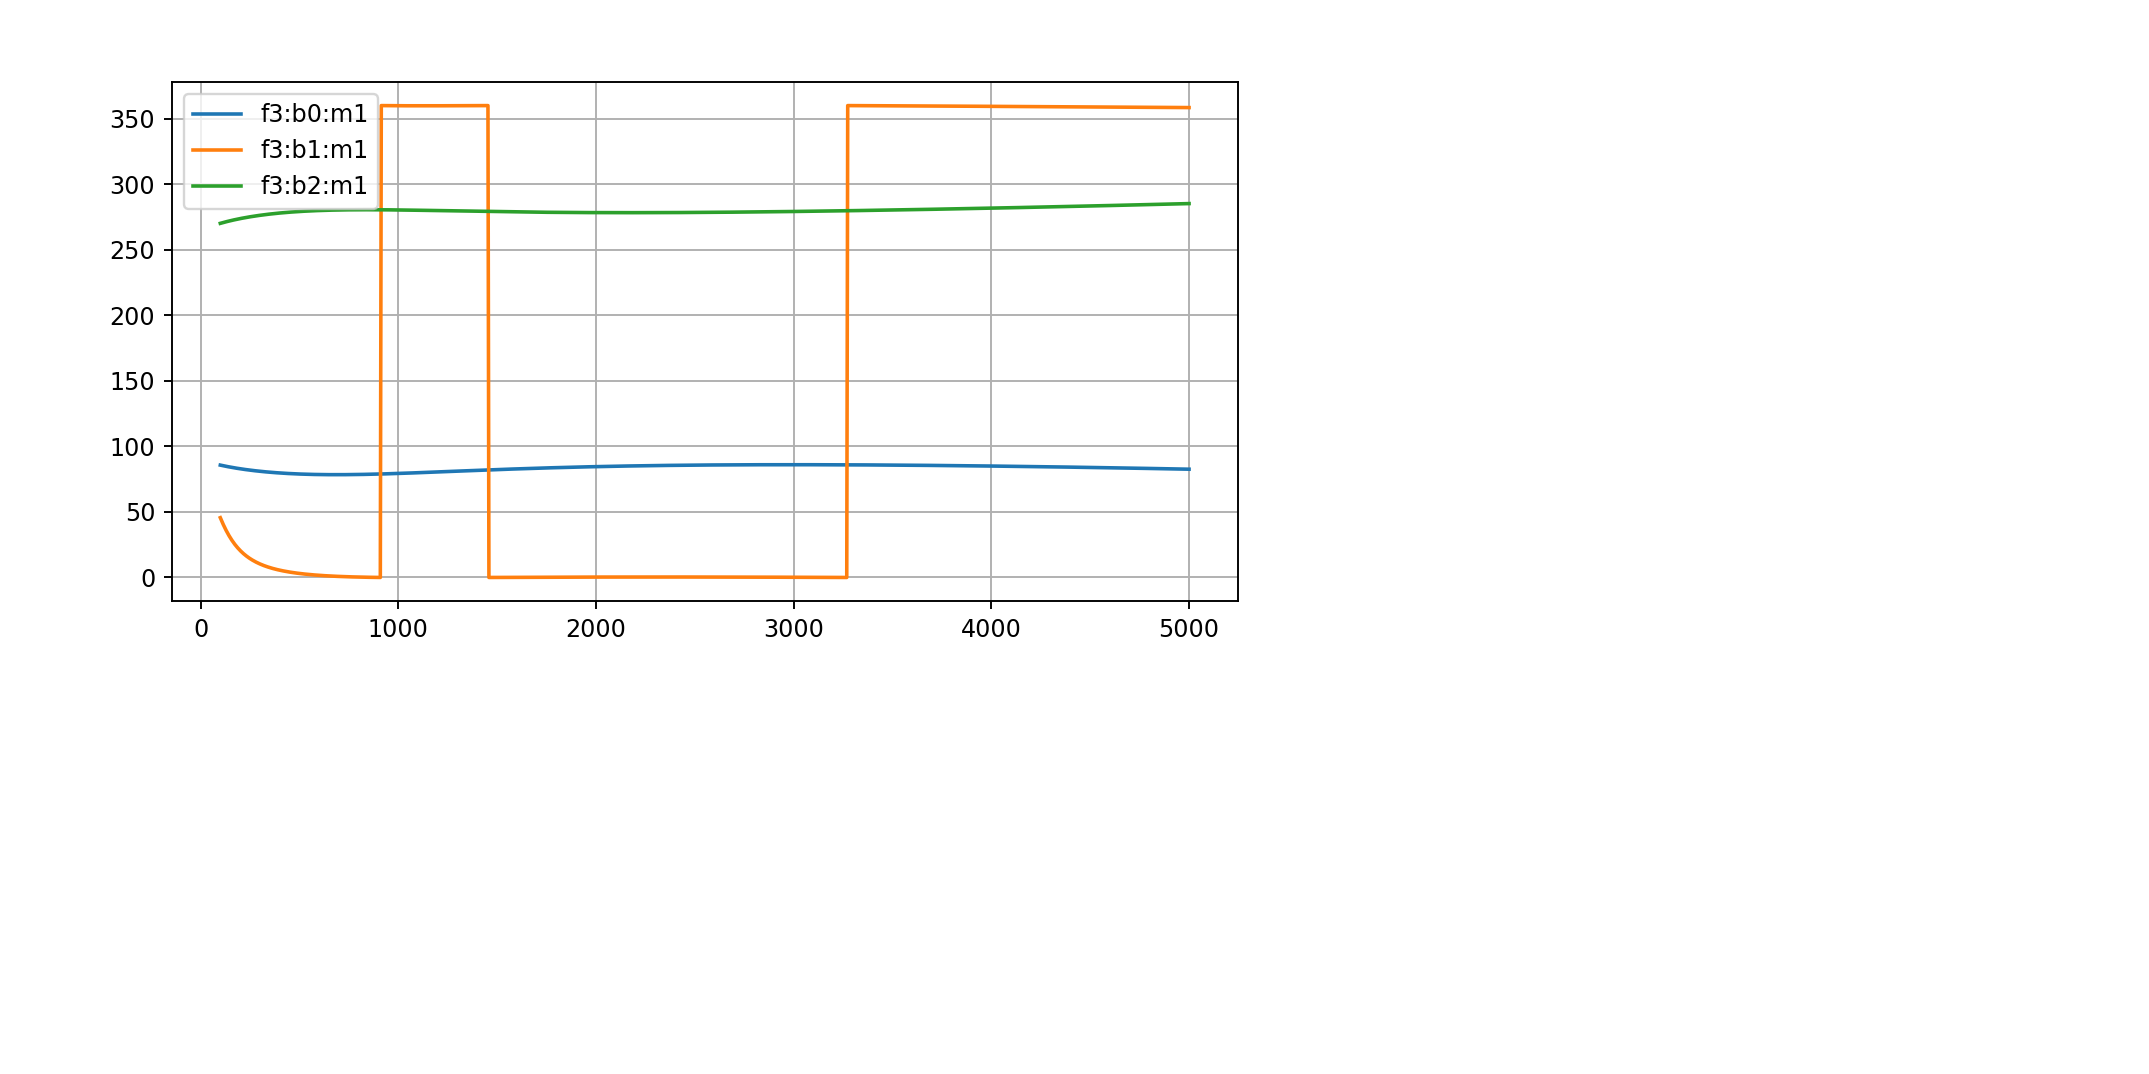

In [253]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
#tmp_beta_ind = 0
tmp_mult_ind = 1
for beta_ind in range(len(phase_results.mult[tmp_freq_ind])):
    phase = np.rad2deg(np.angle(phase_results.mult[tmp_freq_ind][beta_ind][tmp_mult_ind]))
    phase[phase<0.] += 360.
    plt.plot(phase_results.H, phase, label="f{}:b{}:m{}".format(tmp_freq_ind, beta_ind, tmp_mult_ind))

plt.grid(True)
plt.legend()

<IPython.core.display.Javascript object>


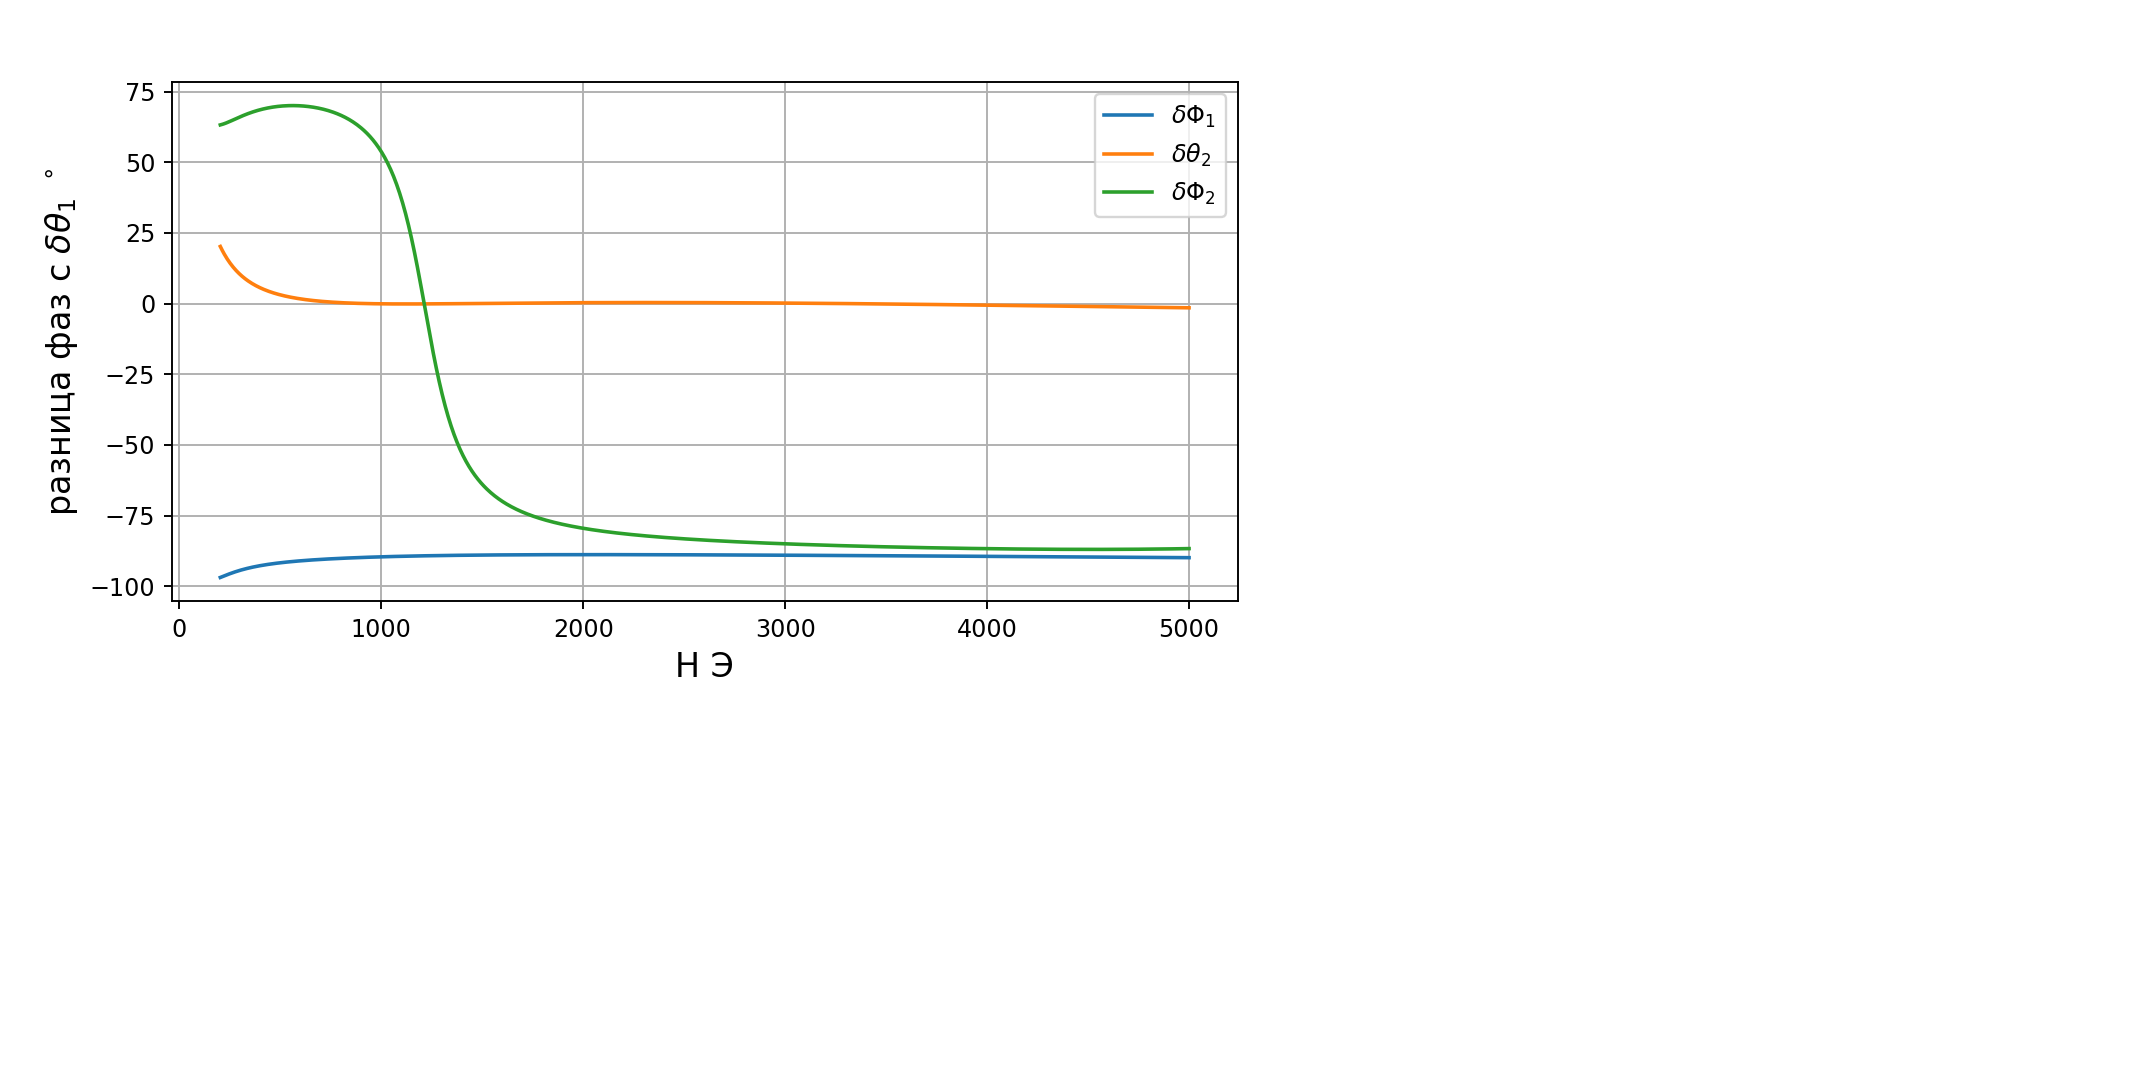

Text(0, 0.5, 'разница фаз с $δθ_1\\ ^\\circ$')

In [256]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
tmp_beta_ind = 1
#tmp_mult_ind = 2
for mult_ind in range(len(phase_results.mult[tmp_freq_ind][tmp_beta_ind])):
    phase = np.rad2deg(np.angle(phase_results.mult[tmp_freq_ind][tmp_beta_ind][mult_ind]))
    phase[phase<100.] += 360.
    phase -= 360
    labels = ["$δΦ_1$", "$δθ_2$", "$δΦ_2$"]
    plt.plot(phase_results.H[phase_results.H>200], phase[phase_results.H>200],
             label=labels[mult_ind])

plt.grid(True)
plt.legend()
plt.xlabel("H Э", fontsize=14)
plt.ylabel(r"разница фаз с $δθ_1\ ^\circ$", fontsize=14)

<IPython.core.display.Javascript object>


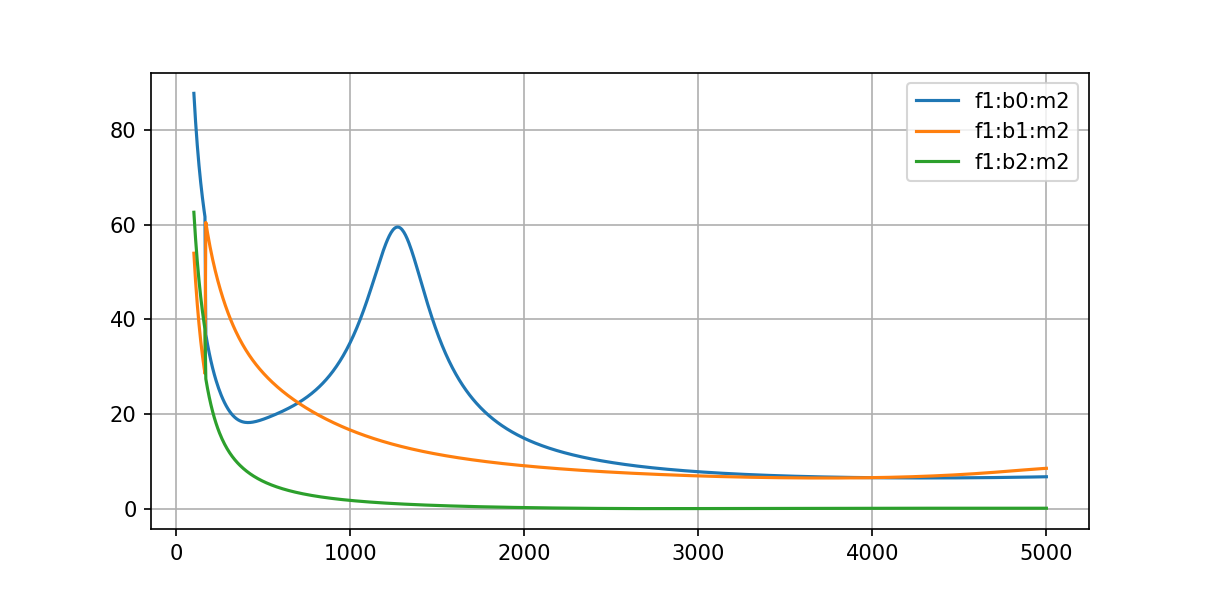

In [247]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

#tmp_freq_ind = 1 #1-our, 3-another positive
#tmp_mult_ind = 1
for beta_ind in range(len(phase_results.mult[tmp_freq_ind])):
    vi_v_abs = np.abs(phase_results.mult[tmp_freq_ind][beta_ind][tmp_mult_ind])
    plt.plot(phase_results.H, vi_v_abs, label="f{}:b{}:m{}".format(tmp_freq_ind, beta_ind, tmp_mult_ind))

plt.grid(True)
plt.legend()

<IPython.core.display.Javascript object>


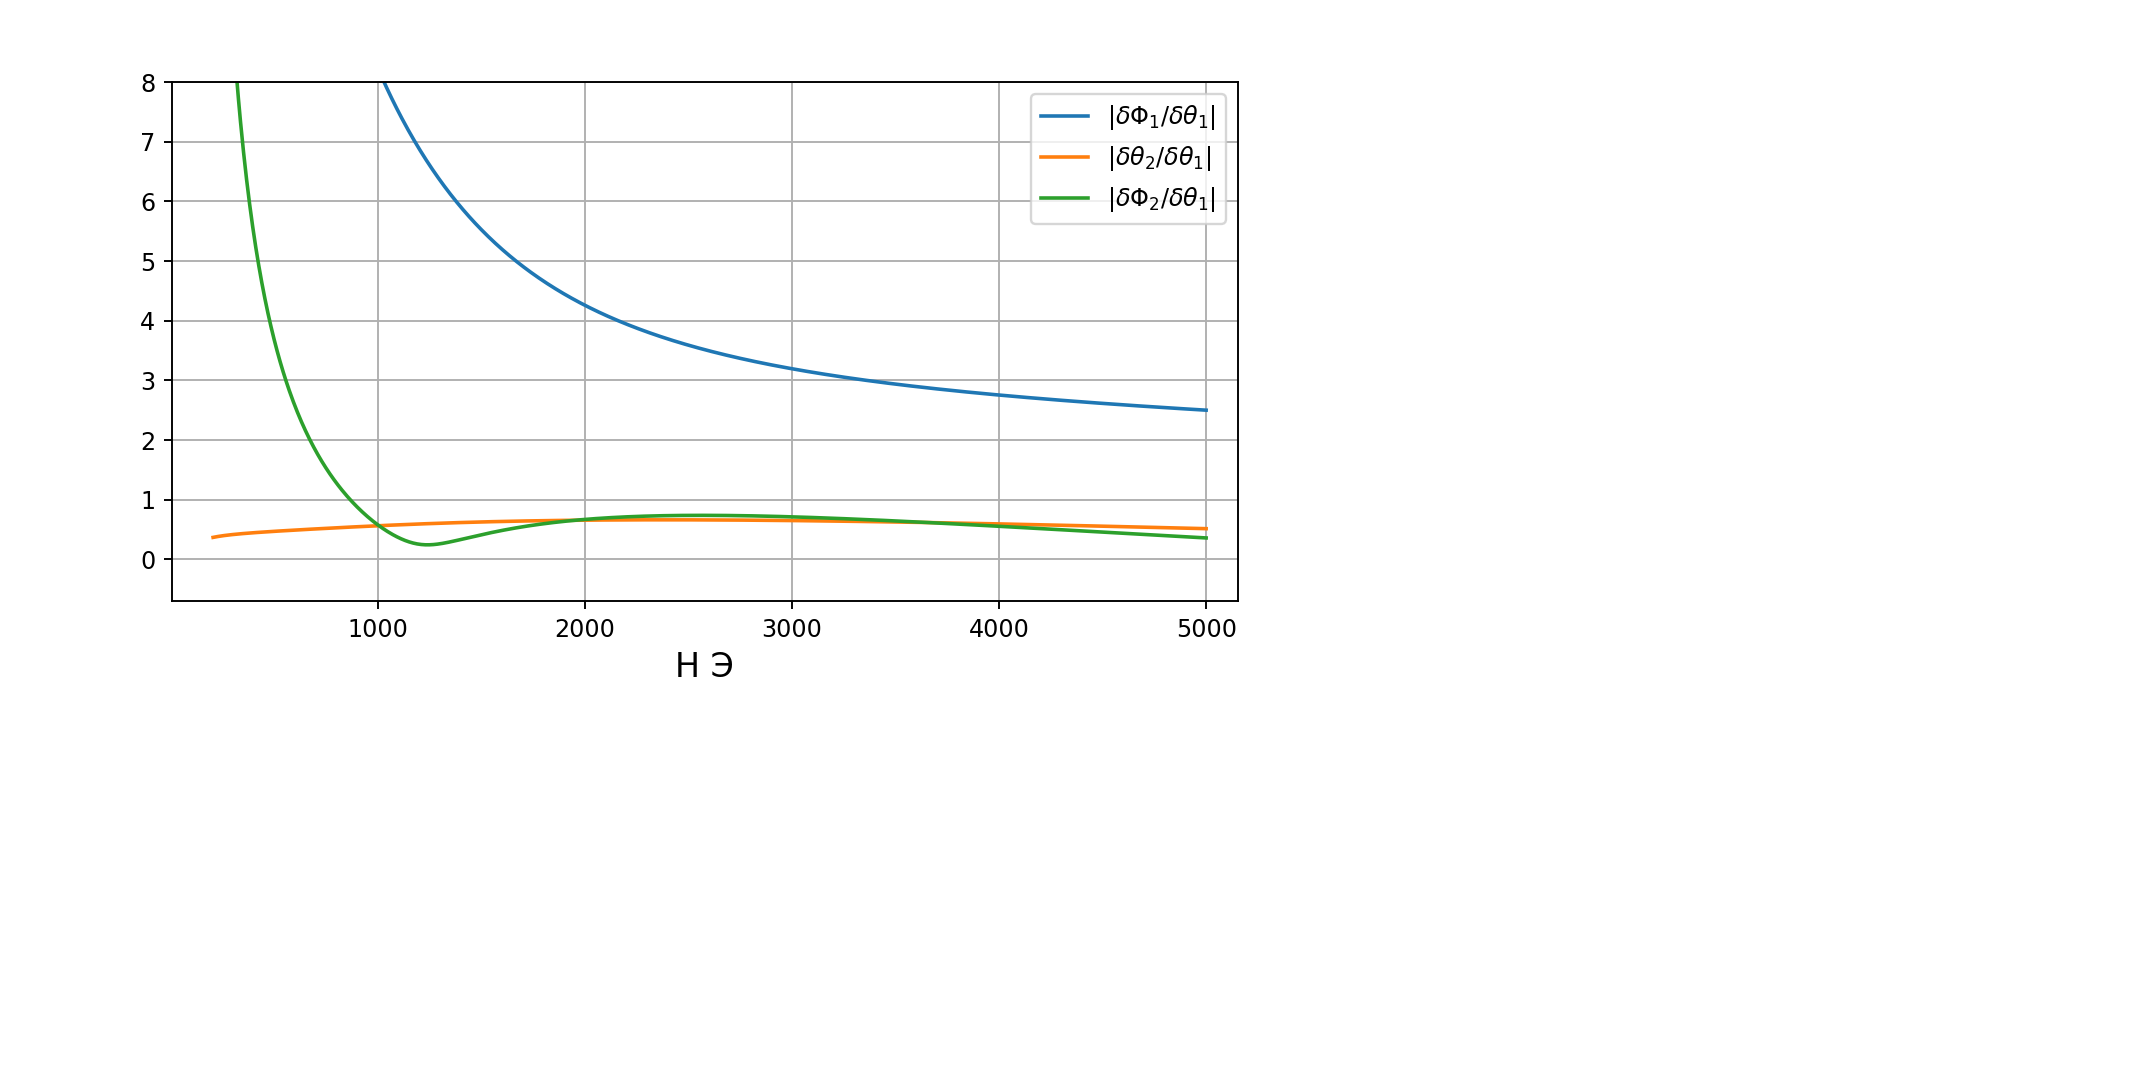

Text(0.5, 0, 'H Э')

In [257]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
tmp_beta_ind = 1
#tmp_mult_ind = 2
for mult_ind in range(len(phase_results.mult[tmp_freq_ind][tmp_beta_ind])):
    vi_v_abs = np.abs(phase_results.mult[tmp_freq_ind][tmp_beta_ind][mult_ind])
    labels = ["$|δΦ_1/δθ_1|$", "$|δθ_2/δθ_1|$", "$|δΦ_2/δθ_1|$"]
    plt.plot(phase_results.H[phase_results.H>200], vi_v_abs[phase_results.H>200],
             label=labels[mult_ind])

plt.grid(True)
plt.legend()
plt.xlabel("H Э", fontsize=14)

<IPython.core.display.Javascript object>


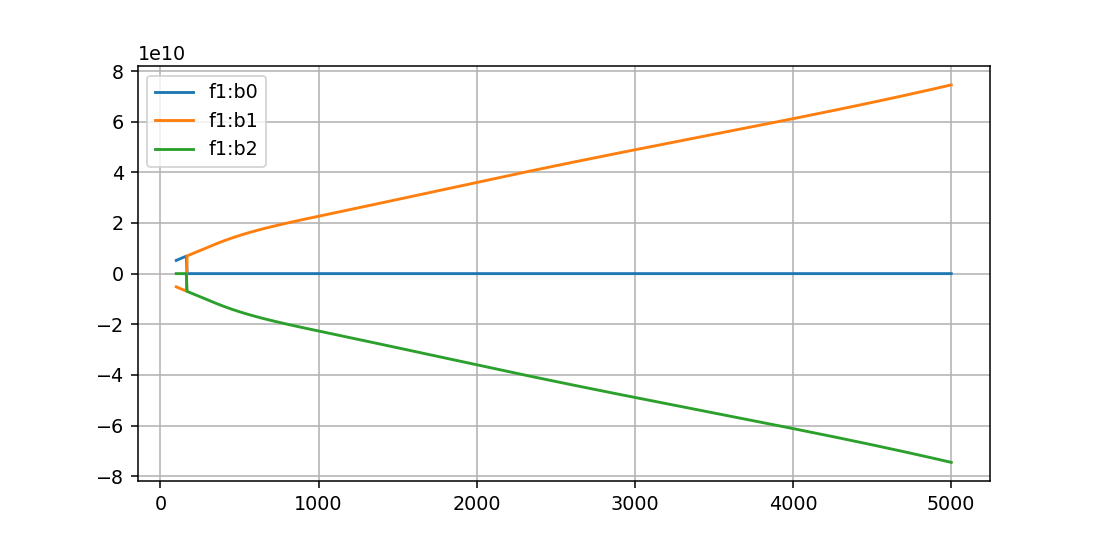

In [234]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)


#tmp_freq_ind = 3 #1-our, 3-another positive
for beta_ind in range(3):
    plt.plot(phase_results.H, np.imag(phase_results.beta_results.beta[tmp_freq_ind][beta_ind]), label="f{}:b{}".format(tmp_freq_ind, beta_ind))

    
plt.grid(True)
plt.legend()

In [129]:
res_atan_deg_f1 = []
res_atan_deg_f3 = []

for i in range(len(results_phase.res_v1_re_f1)):
    res_atan_deg_f1_tmp = np.zeros((len(results_phase.Hax),))
    res_atan_deg_f3_tmp = np.zeros((len(results_phase.Hax),))
    
    #res_atan_deg_f1_tmp = np.rad2deg(
    #    mp.atan(
    #        np.array(np.real(results_phase.res_v1_im_f1[i])) / np.array(np.real(results_phase.res_v1_re_f1[i]))
    #    )
    #)
    #res_atan_deg_f3_tmp = np.rad2deg(
    #    np.arctan(
    #        np.array(np.real(results_phase.res_v1_im_f3[i])) / np.array(np.real(results_phase.res_v1_re_f3[i]))
    #    )
    #)
    
    for j in range(len(results_phase.Hax)):
        res_atan_deg_f1_tmp[j] = np.rad2deg(np.float64(mp.atan(
            results_phase.res_v1_im_f1[i][j].real/results_phase.res_v1_re_f1[i][j].real
        )))
        if np.real(results_phase.res_v1_re_f1[i][j]) < 0:
            res_atan_deg_f1_tmp[j]+=180.
        if res_atan_deg_f1_tmp[j] < 0.:
            res_atan_deg_f1_tmp[j] += 360.
    
    for j in range(len(results_phase.Hax)):
        res_atan_deg_f3_tmp[j] = np.rad2deg(np.float64(mp.atan(
            results_phase.res_v1_im_f3[i][j].real/results_phase.res_v1_re_f3[i][j].real
        )))
        if np.real(results_phase.res_v1_re_f3[i][j]) < 0:
            res_atan_deg_f3_tmp[j]+=180.
        if res_atan_deg_f3_tmp[j] < 0.:
            res_atan_deg_f3_tmp[j] += 360.
    
    res_atan_deg_f1.append(res_atan_deg_f1_tmp)
    res_atan_deg_f3.append(res_atan_deg_f3_tmp)
    

<IPython.core.display.Javascript object>


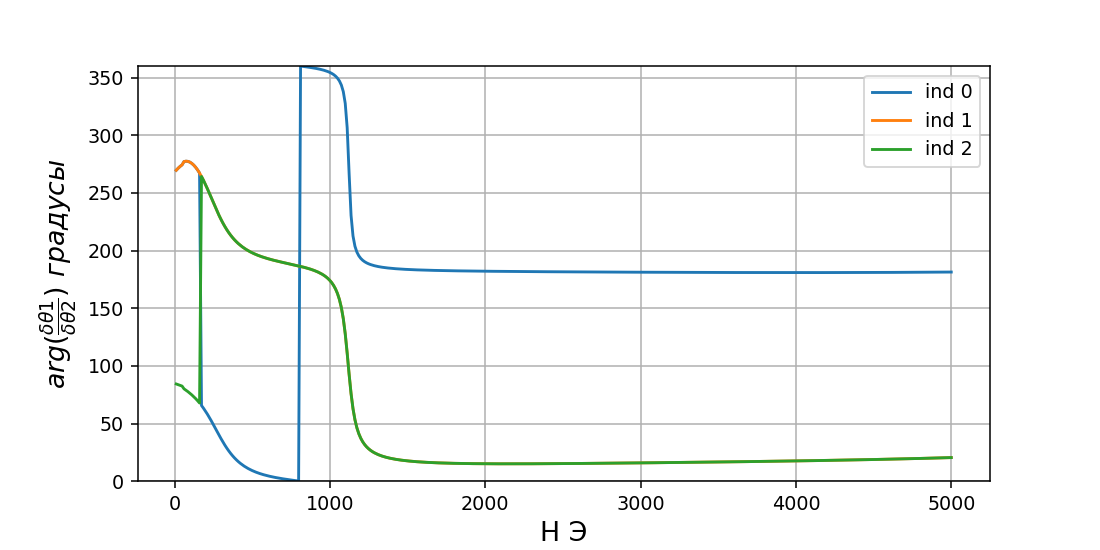

Text(0, 0.5, '$arg(\\frac{δθ1}{δθ2})\\ градусы$')

In [157]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

#for i in [0]:#range(len(res_atan_deg_f1)):
#    plt.plot(results_phase.Hax, res_atan_deg_f1[i], label="mod 1")
#
#for i in [1]:
#    plt.plot(results_phase.Hax, res_atan_deg_f3[i], label="mod 2")

for i in range(len(res_atan_deg_f1)):
    plt.plot(results_phase.Hax, res_atan_deg_f1[i], label="ind {}".format(i))
    
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 360)
plt.xlabel('H Э', fontsize=14)
plt.ylabel(r"$arg(\frac{δθ1}{δθ2})\ градусы$", fontsize=14)
#plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


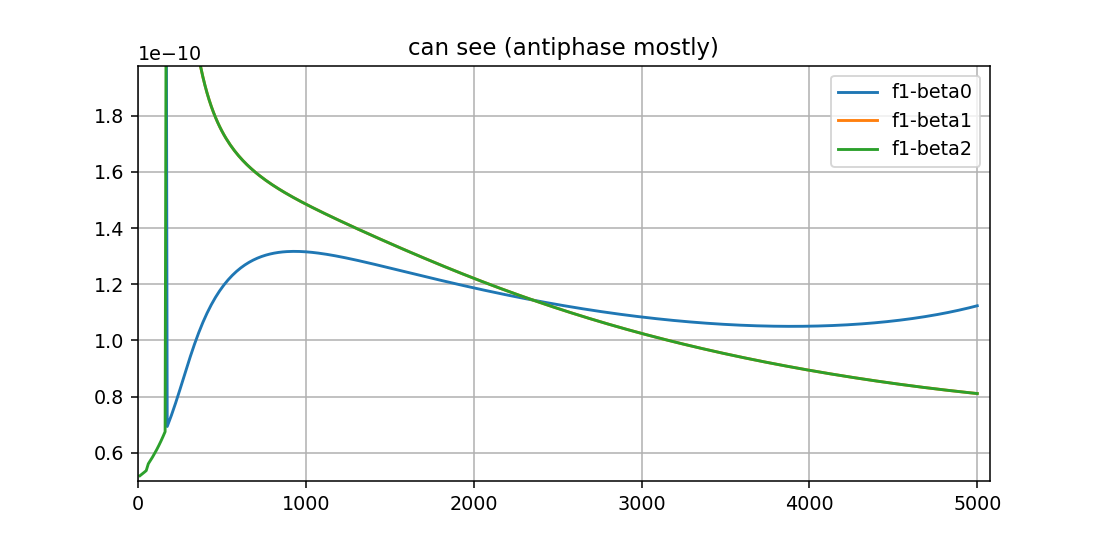

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [135]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in range(len(results_phase.res_beta_f1)):
    tmp = []
    for j in range(len(results_phase.res_beta_f1[i])): tmp.append(np.float64(results_phase.res_beta_f1[i][j].real))
    plt.plot(results_phase.Hax, 1./np.array(tmp), label="f1-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


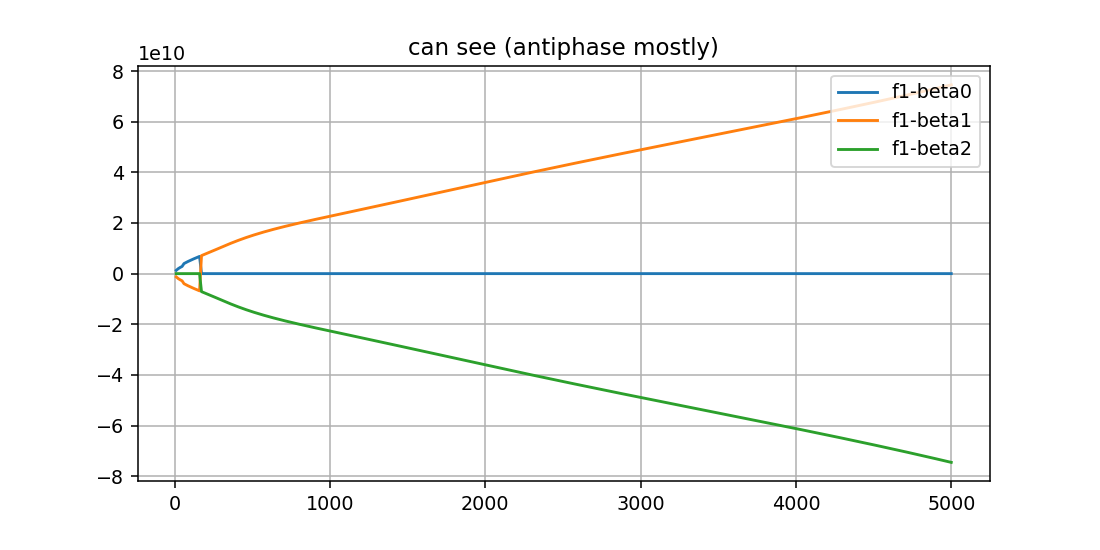

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [136]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in range(len(results_phase.res_beta_f1)):
    tmp = []
    for j in range(len(results_phase.res_beta_f1[i])): tmp.append(np.float64(results_phase.res_beta_f1[i][j].imag))
    plt.plot(results_phase.Hax, tmp, label="f1-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


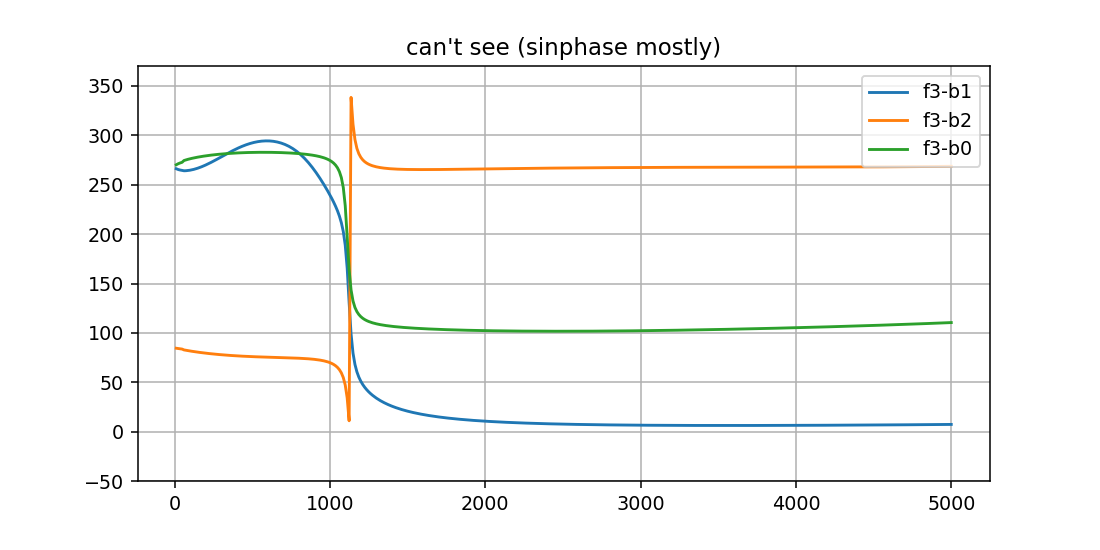

Text(0.5, 1.0, "can't see (sinphase mostly)")

In [155]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    plt.plot(results_phase.Hax, res_atan_deg_f3[i], label="f3-b{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-50, 370)
plt.title("can't see (sinphase mostly)")

<IPython.core.display.Javascript object>


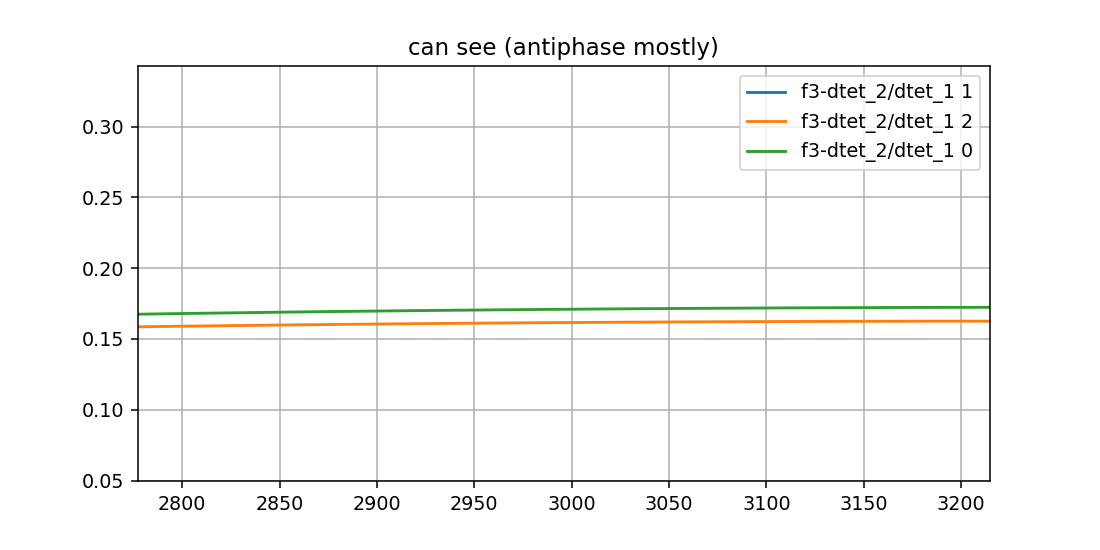

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [156]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_res = []
for i in [1,2,0]:
    tmp = np.sqrt(np.real(np.array(results_phase.res_v1_re_f3[i]))**2 + np.real(np.array(results_phase.res_v1_im_f3[i]))**2)
    if(i==1): tmp_res = tmp
    plt.plot(results_phase.Hax, tmp, label="f3-dtet_2/dtet_1 {}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

In [153]:
#tmp_res[results_phase.Hax>1999]

<IPython.core.display.Javascript object>


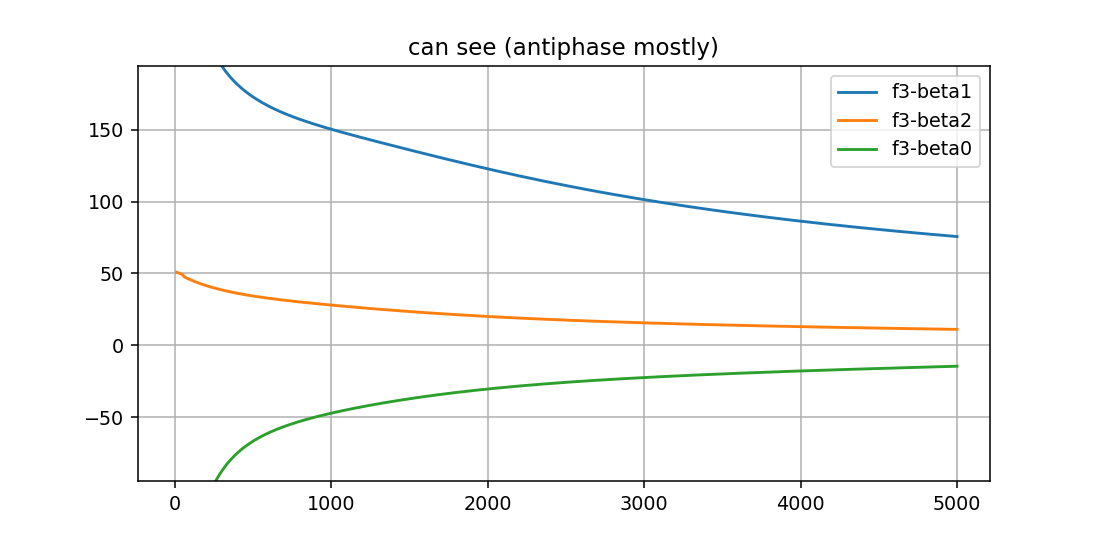

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [154]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    tmp = []
    for j in range(len(results_phase.res_beta_f3[i])): tmp.append(np.float64(results_phase.res_beta_f3[i][j].real))
    plt.plot(results_phase.Hax, 1./np.array(tmp)*1e12, label="f3-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


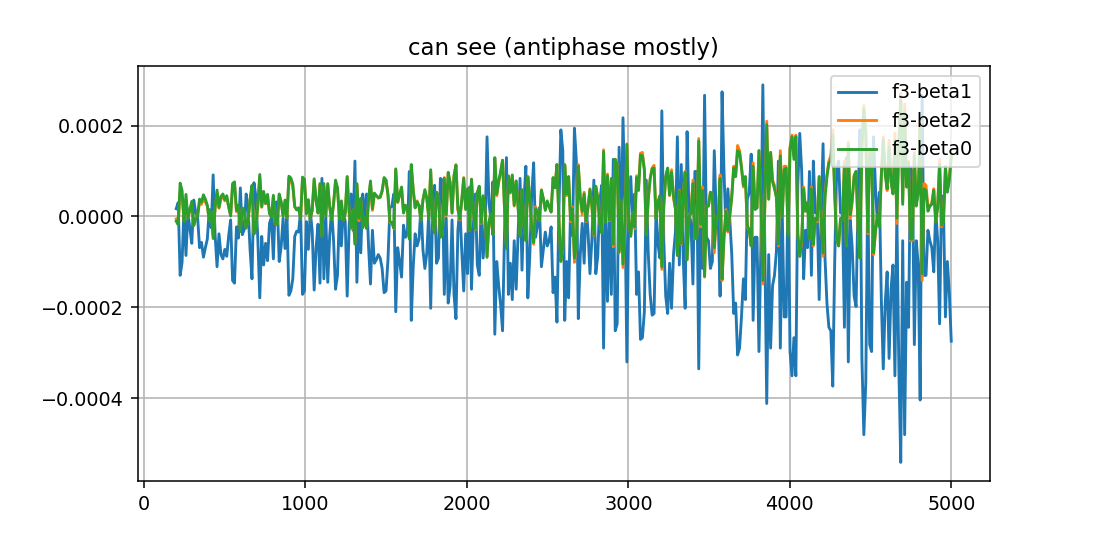

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [127]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    tmp = []
    for j in range(len(results_phase.res_beta_f3[i])): tmp.append(np.float64(results_phase.res_beta_f3[i][j].imag))
    plt.plot(results_phase.Hax, tmp, label="f3-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

In [120]:
results_phase.res_beta_f3[2][8].imag

2.47955322265625e-05

<IPython.core.display.Javascript object>


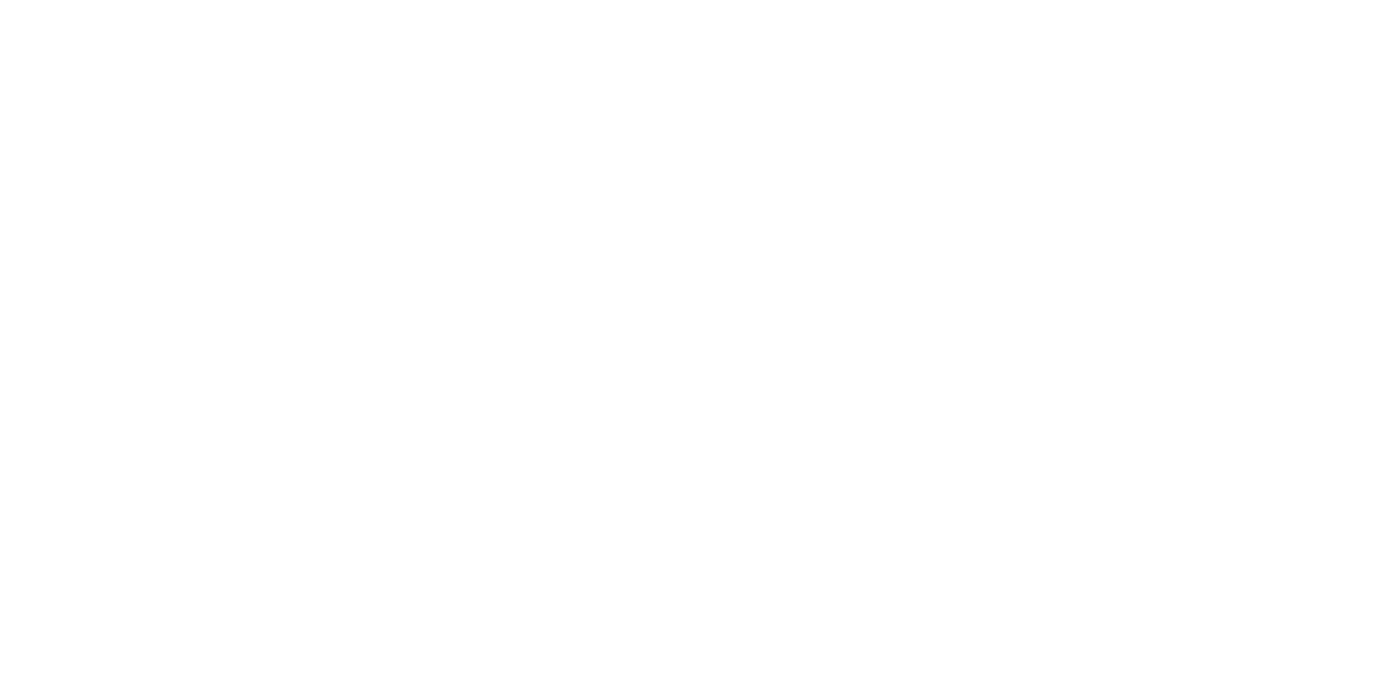

AttributeError: 'PhaseResults' object has no attribute 'res_beta'

In [121]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)
plt.plot(results_phase.Hax, np.array(results_phase.res_freq1)*1e-9, label='freq1')
plt.plot(results_phase.Hax, np.array(results_phase.res_freq3)*1e-9, label='freq3')
plt.plot(results_phase.Hax, np.array(results_phase.res_beta)*1e-9, label='beta')
plt.plot(results_phase.Hax, results_phase.res_v1_re, label='re')
plt.plot(results_phase.Hax, results_phase.res_v1_im, label='im')
plt.plot(results_phase.Hax, res_atan_deg, label='atan')
plt.plot(results_phase.Hax, results_phase.res_ang1)
plt.plot(results_phase.Hax, results_phase.res_ang2)
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-50, 370)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)
plt.plot(results_phase.Hax, results_phase.res_v1_im, label='im')
plt.plot(results_phase.Hax, results_phase.res_v1_re, label='re')
plt.grid(True)
plt.legend()

In [ ]:
rr_tmp = np.array(results_phase.res_beta)
np.imag(rr_tmp)/np.real(rr_tmp)

In [ ]:
results_phase.Hax